In [1]:
# import preprocess as prep
import SLR_model
import SLR_model_GRU
import numpy as np
import tensorflow as tf
from tensorflow import keras
import time
import os
import json
import importlib
from matplotlib import pyplot as plt
import preprocess
# from preprocess import person

# model will output multiple(5) results/sec, how are we gonna handle it?

In [2]:
load_size = 3000 # number of data to be loaded at once
epochs = 50
run_time=2
batch_size = 16
save_dir = "saves_GRU"
load_dir = "saves_GRU"
model = SLR_model_GRU.get_model()

In [3]:
 # reload model file
end_file=preprocess.getoutputdir()

save_suffix = time.strftime("%m-%d-%H", time.localtime(time.time()))
ckpt_name=save_suffix+"-"+str(epochs)+"epochs-"+str(run_time)+"times"

check_path = os.path.join(save_dir,'ckpt',ckpt_name)
hist_path = os.path.join(save_dir, "hist",ckpt_name+".json")

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
filepath=f'{check_path}.keras',
monitor='categorical_accuracy',
mode='max',
save_freq='epoch',
save_best_only=True)


start_person=1
start_count=1
start_word=" "
for i in range(1,17):
    l_raws=[]
    r_raws=[]
    p_raws=[]
    y_raws=[]
    loss_weights_raws=[]
    if start_person>i:
        continue
    for k in range(1,run_time+1):
        if start_count>k:
            continue
        elif start_count==k:
            start_count=0
        for j in sorted(os.listdir(os.path.join(preprocess.getoutputdir(),str(i)))):
            if len(l_raws)==0:
                start_word = j
            else:
                end_word = j
            l_raw, r_raw, p_raw, y_raw, loss_weights_raw = preprocess.load_data(f"{i}/{j}")
            l_raws.append(l_raw)
            r_raws.append(r_raw)
            p_raws.append(p_raw)
            y_raws.append(y_raw)
            loss_weights_raws.append(loss_weights_raw)
            # print(p_raw.shape)
            # break
            if len(l_raws)>=load_size:
                with open(os.path.join('logs',ckpt_name+'.txt'), 'a') as logs:
                    logs.write(f'{ time.strftime("%H-%M-%S", time.localtime(time.time()))}:{k}) person:{i} : {start_word} ~ {end_word}\n')  # 한 줄 쓰기
                l_train, each = SLR_model_GRU.serialize(l_raws)
                r_train, each = SLR_model_GRU.serialize(r_raws)
                p_train, each, sample_weights = SLR_model_GRU.serialize(p_raws, stride=2, loss_weights_list=loss_weights_raws)
                x_train = (l_train, r_train, p_train)
                
                y_train = np.repeat(y_raws, each)
                y_train = SLR_model_GRU.encode_onehot2d(y_train)
                
                dataset = SLR_model_GRU.convert_to_dataset(x_train, y_train, batch_size, sample_weights)
                hist = model.fit(dataset, epochs=epochs, callbacks=[model_checkpoint_callback])
                
                with open(hist_path, 'w') as file:
                    json.dump(hist.history, file)
                l_raws.clear()
                r_raws.clear()
                p_raws.clear()
                y_raws.clear()
                loss_weights_raws.clear()
        if len(l_raws)>0:
            l_train, each = SLR_model_GRU.serialize(l_raws)
            r_train, each = SLR_model_GRU.serialize(r_raws)
            p_train, each, sample_weights = SLR_model_GRU.serialize(p_raws, stride=2, loss_weights_list=loss_weights_raws)
            x_train = (l_train, r_train, p_train)
            
            y_train = np.repeat(y_raws, each)
            y_train = SLR_model_GRU.encode_onehot2d(y_train)
            
            
            dataset = SLR_model_GRU.convert_to_dataset(x_train, y_train, batch_size, sample_weights)
            
           
            hist = model.fit(dataset, epochs=epochs, callbacks=[model_checkpoint_callback])
            
            with open(hist_path, 'w') as file:
                json.dump(hist.history, file)

    

Epoch 1/50
(16, 9, 4, 5, 3)
(16, 1, 2, 3, 1)
(16, 9, 4, 5, 3)
(16, 1, 2, 3, 1)
(16, 9, 4, 5, 3)
(16, 1, 2, 3, 1)
(16, 9, 4, 5, 3)
(16, 1, 2, 3, 1)
Left Hand Result Shape: (16, 1, 6)
Right Hand Result Shape: (16, 1, 6)
Pose Result Shape: (16, 1, 3)
(16, 15)
(16, 9, 4, 5, 3)
(16, 1, 2, 3, 1)
(16, 9, 4, 5, 3)
(16, 1, 2, 3, 1)
Left Hand Result Shape: (16, 1, 6)
Right Hand Result Shape: (16, 1, 6)
Pose Result Shape: (16, 1, 3)
(16, 15)


/home/shd/.conda/envs/BomNae-SLR/lib/python3.9/site-packages/keras/src/layers/layer.py:1331: UserWarning: Layer 'slr_model_1' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''Shapes must be equal rank, but are 2 and 0
	From merging shape 0 with other shapes. for '{{node zeros/packed}} = Pack[N=2, T=DT_INT32, axis=0](zeros/Cast, zeros/packed/1)' with input shapes: [16,15], [].''
  warnings.warn(
/home/shd/.conda/envs/BomNae-SLR/lib/python3.9/site-packages/keras

ValueError: Exception encountered when calling SLRModel.call().

[1mShapes must be equal rank, but are 2 and 0
	From merging shape 0 with other shapes. for '{{node slr_model_1_1/zeros/packed}} = Pack[N=2, T=DT_INT32, axis=0](slr_model_1_1/zeros/Cast, slr_model_1_1/zeros/packed/1)' with input shapes: [16,15], [].[0m

Arguments received by SLRModel.call():
  • inputs=('tf.Tensor(shape=(16, 9, 4, 5, 3), dtype=float32)', 'tf.Tensor(shape=(16, 9, 4, 5, 3), dtype=float32)', 'tf.Tensor(shape=(16, 5, 3, 10), dtype=float32)')
  • states=None
  • return_states=False
  • training=True

In [ ]:
# Configurations
load_size = 3000 # number of data to be loaded at once
epochs = 50
batch_size = 16
save_dir = "saves"
load_dir = "saves"
# load_path = "C:/Users/jerry/Desktop/hly/2024-2/cap/BN_SLR/BomNae-SLR/checkpoints.keras"


In [ ]:
model = SLR_model.get_model()

In [ ]:
 # reload model file
importlib.reload(SLR_model)
importlib.reload(preprocess)
end_file=preprocess.getoutputdir()

save_suffix = time.strftime("_%d-%H-%M", time.localtime(time.time()))


# checkTime="_14-16-16"
# check_path = os.path.join(save_dir, "check"+checkTime)
# hist_path = os.path.join(save_dir, "hist"+checkTime+".json")

check_path = os.path.join(save_dir, "check"+save_suffix+"_50epochs_3time")
hist_path = os.path.join(save_dir, "hist"+save_suffix+".json")

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
filepath=f'{check_path}.keras',
monitor='categorical_accuracy',
mode='max',
save_freq='epoch',
save_best_only=True)


start_person=1
start_count=1
start_word=" "
for i in range(1,17):
    l_raws=[]
    r_raws=[]
    p_raws=[]
    y_raws=[]
    loss_weights_raws=[]
    if start_person>i:
        continue
    for k in range(1,2):
        if start_count>k:
            continue
        elif start_count==k:
            start_count=0
        for j in sorted(os.listdir(os.path.join(preprocess.getoutputdir(),str(i)))):
            if len(l_raws)==0:
                start_word = j
            else:
                end_word = j
            l_raw, r_raw, p_raw, y_raw, loss_weights_raw = preprocess.load_data(f"{i}/{j}")
            l_raws.append(l_raw)
            r_raws.append(r_raw)
            p_raws.append(p_raw)
            y_raws.append(y_raw)
            loss_weights_raws.append(loss_weights_raw)
    
            if len(l_raws)>=load_size:
                with open(str(i)+'training_log.txt', 'a') as logs:
                    logs.write(f'{ time.strftime("%H-%M-%S", time.localtime(time.time()))}:{k}) person:{i} : {start_word} ~ {end_word}\n')  # 한 줄 쓰기
                print(f"{k}) person:{i} : {start_word} ~ {end_word}\n\n\n\n")
                l_train, each = SLR_model.serialize(l_raws)
                r_train, each = SLR_model.serialize(r_raws)
                p_train, each, sample_weights = SLR_model.serialize(p_raws, stride=2, loss_weights_list=loss_weights_raws)
                x_train = (l_train, r_train, p_train)
                
                y_train = np.repeat(y_raws, each)
                y_train = SLR_model.encode_onehot2d(y_train)
    
                dataset = SLR_model.convert_to_dataset(x_train, y_train, batch_size, sample_weights)
                hist = model.fit(dataset, epochs=epochs, callbacks=[model_checkpoint_callback])
                
                with open(hist_path, 'w') as file:
                    json.dump(hist.history, file)
                l_raws.clear()
                r_raws.clear()
                p_raws.clear()
                y_raws.clear()
                loss_weights_raws.clear()
        if len(l_raws)>0:
            l_train, each = SLR_model.serialize(l_raws)
            r_train, each = SLR_model.serialize(r_raws)
            p_train, each, sample_weights = SLR_model.serialize(p_raws, stride=2, loss_weights_list=loss_weights_raws)
            x_train = (l_train, r_train, p_train)
            
            y_train = np.repeat(y_raws, each)
            y_train = SLR_model.encode_onehot2d(y_train)
    
            dataset = SLR_model.convert_to_dataset(x_train, y_train, batch_size, sample_weights)
            hist = model.fit(dataset, epochs=epochs, callbacks=[model_checkpoint_callback])
            
            with open(hist_path, 'w') as file:
                json.dump(hist.history, file)

    

In [ ]:
# hand input shape: (batch, time, h, w, channels)
# pose input shape: (batch, time, channel, features)

In [ ]:
# # 세이브된 모델 로드
# load_path = os.join(load_dir, "check_00-00-00.keras")
# model = SLR_model.load_model(load_path)

In [ ]:
# # 안될때 (강제중지 + 초기화)
# tf.keras.backend.clear_session()

In [ ]:
# l_raws=[]
# r_raws=[]
# p_raws=[]
# y_raws=[]


# save_suffix = time.strftime("_%d-%H-%M", time.localtime(time.time()))
# check_path = os.path.join(save_dir, "check"+save_suffix)
# hist_path = os.path.join(save_dir, "hist"+save_suffix+".json")

# model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
#     filepath=f'{check_path}.keras',
#     monitor='binary_accuracy',
#     mode='max',
#     save_freq='epoch',
#     save_best_only=True)



# l_raw, r_raw, p_raw, y_raw = preprocess.load_data(f"1/1")

# l_raws.append(l_raw)
# r_raws.append(r_raw)
# p_raws.append(p_raw)
# y_raws.append(y_raw)


# l_train, each = SLR_model.serialize(l_raws)
# r_train, each = SLR_model.serialize(r_raws)
# p_train, each = SLR_model.serialize(p_raws, stride=2)
# y_train = np.repeat(y_raws, each)
# y_train = SLR_model.num_arr2bin(y_train, 12)
# x_train = (l_train, r_train, p_train)

# # dataset = SLR_model.convert_to_dataset(x_train, y_train, batch_size)
# hist = model.fit(x_train, y_train, batch_size = 2, epochs=epochs, callbacks=[model_checkpoint_callback])

# with open(hist_path, 'w') as file:
#     json.dump(hist.history, file)


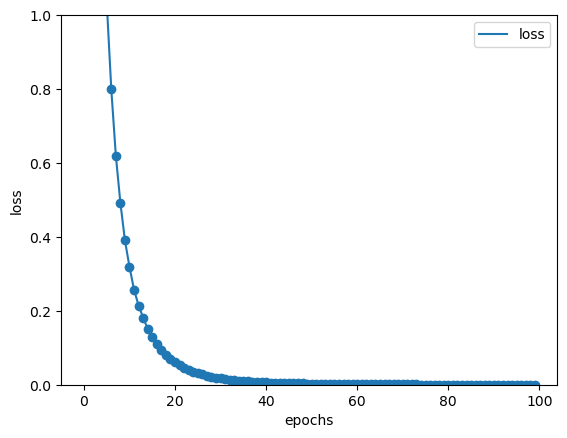

In [23]:
plt.plot(range(len(hist.history['loss'])), hist.history['loss'])
plt.scatter(range(len(hist.history['loss'])), hist.history['loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["loss"])
plt.ylim((0,1))
plt.show()

In [11]:
print(os.listdir(os.path.join(preprocess.getoutputdir(),str(15))))

['1962.npz', '2811.npz', '0220.npz', '2020.npz', '1494.npz', '0966.npz', '0039.npz', '0170.npz', '2124.npz', '1381.npz', '2545.npz', '1198.npz', '2965.npz', '0860.npz', '2651.npz', '0064.npz', '2842.npz', '1834.npz', '0796.npz', '1738.npz', '0242.npz', '0295.npz', '2218.npz', '0041.npz', '1023.npz', '0310.npz', '1108.npz', '2169.npz', '0068.npz', '2802.npz', '2268.npz', '0694.npz', '1440.npz', '0326.npz', '0570.npz', '1350.npz', '1863.npz', '1143.npz', '2425.npz', '1983.npz', '1332.npz', '1954.npz', '1623.npz', '2371.npz', '1838.npz', '2966.npz', '1484.npz', '0586.npz', '2557.npz', '2761.npz', '1532.npz', '0615.npz', '1295.npz', '0212.npz', '0070.npz', '0019.npz', '1998.npz', '1202.npz', '1763.npz', '1570.npz', '2672.npz', '0574.npz', '2800.npz', '2388.npz', '0739.npz', '2718.npz', '0139.npz', '1876.npz', '1636.npz', '2633.npz', '1756.npz', '2725.npz', '1323.npz', '1236.npz', '1614.npz', '0245.npz', '0949.npz', '0105.npz', '2980.npz', '1569.npz', '0887.npz', '2541.npz', '2497.npz', '00

In [ ]:
model.metrics_names